In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/Admin/Desktop/Radhika work/Zeta Work/sales_data_sample.csv", encoding='latin1')

In [15]:
# ------------------------------------------
# 3. CLEANING FUNCTIONS
# ------------------------------------------

def remove_duplicates(df):
    return df.drop_duplicates()


def convert_dates(df, date_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df


def trim_whitespace(df):
    str_cols = df.select_dtypes(include=['object']).columns
    df[str_cols] = df[str_cols].apply(lambda x: x.str.strip())
    return df


def fill_missing_values(df):
    # Numeric → median
    num_cols = df.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    # Categorical → mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].mode().size > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

    return df


def standardize_text_columns(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].str.title()
    return df

def top_10_products(df):
    top_products = (
        df.groupby('PRODUCTLINE')['SALES']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    return top_products

In [16]:
# ------------------------------------------
# 4. APPLY CLEANING
# ------------------------------------------

df = remove_duplicates(df)
df = convert_dates(df, ['ORDERDATE'])
df = trim_whitespace(df)
df = fill_missing_values(df)
df = standardize_text_columns(df, ['CITY', 'COUNTRY', 'STATE', 'DEALSIZE', 'STATUS'])

In [17]:
# ------------------------------------------
# 5. FEATURE ENGINEERING
# ------------------------------------------

# Extract Year, Month, Quarter from ORDERDATE
df['Order_Year'] = df['ORDERDATE'].dt.year
df['Order_Month'] = df['ORDERDATE'].dt.month
df['Order_Quarter'] = df['ORDERDATE'].dt.quarter

# Create Revenue Category
df['Revenue_Category'] = pd.cut(
    df['SALES'],
    bins=[0, 1000, 5000, 10000, np.inf],
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [18]:
# ------------------------------------------
# 6. EDA FUNCTIONS
# ------------------------------------------

def missing_summary(df):
    print("\nMissing Values Summary:")
    print(df.isnull().sum())


def numeric_summary(df):
    print("\nNumeric Columns Summary:")
    print(df.describe())


def categorical_summary(df):
    print("\nCategorical Value Counts:")
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        print(f"\n--- {col} ---")
        print(df[col].value_counts().head())

In [19]:
# ------------------------------------------
# 7. RUN EDA 
# ------------------------------------------

missing_summary(df)


Missing Values Summary:
ORDERNUMBER         0
QUANTITYORDERED     0
PRICEEACH           0
ORDERLINENUMBER     0
SALES               0
ORDERDATE           0
STATUS              0
QTR_ID              0
MONTH_ID            0
YEAR_ID             0
PRODUCTLINE         0
MSRP                0
PRODUCTCODE         0
CUSTOMERNAME        0
PHONE               0
ADDRESSLINE1        0
ADDRESSLINE2        0
CITY                0
STATE               0
POSTALCODE          0
COUNTRY             0
TERRITORY           0
CONTACTLASTNAME     0
CONTACTFIRSTNAME    0
DEALSIZE            0
Order_Year          0
Order_Month         0
Order_Quarter       0
Revenue_Category    0
SALES_Z             0
dtype: int64


In [20]:
numeric_summary(df)


Numeric Columns Summary:
        ORDERNUMBER  QUANTITYORDERED    PRICEEACH  ORDERLINENUMBER  \
count   2823.000000      2823.000000  2823.000000      2823.000000   
mean   10258.725115        35.092809    83.658544         6.466171   
min    10100.000000         6.000000    26.880000         1.000000   
25%    10180.000000        27.000000    68.860000         3.000000   
50%    10262.000000        35.000000    95.700000         6.000000   
75%    10333.500000        43.000000   100.000000         9.000000   
max    10425.000000        97.000000   100.000000        18.000000   
std       92.085478         9.741443    20.174277         4.225841   

              SALES                      ORDERDATE       QTR_ID     MONTH_ID  \
count   2823.000000                           2823  2823.000000  2823.000000   
mean    3553.889072  2004-05-11 00:16:49.989373056     2.717676     7.092455   
min      482.130000            2003-01-06 00:00:00     1.000000     1.000000   
25%     2203.430000    

In [21]:
categorical_summary(df)


Categorical Value Counts:

--- STATUS ---
STATUS
Shipped       2617
Cancelled       60
Resolved        47
On Hold         44
In Process      41
Name: count, dtype: int64

--- PRODUCTLINE ---
PRODUCTLINE
Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Name: count, dtype: int64

--- PRODUCTCODE ---
PRODUCTCODE
S18_3232    52
S10_1949    28
S24_1444    28
S10_4962    28
S24_2840    28
Name: count, dtype: int64

--- CUSTOMERNAME ---
CUSTOMERNAME
Euro Shopping Channel           259
Mini Gifts Distributors Ltd.    180
Australian Collectors, Co.       55
La Rochelle Gifts                53
AV Stores, Co.                   51
Name: count, dtype: int64

--- PHONE ---
PHONE
(91) 555 94 44    259
4155551450        180
03 9520 4555       55
40.67.8555         53
(171) 555-1555     51
Name: count, dtype: int64

--- ADDRESSLINE1 ---
ADDRESSLINE1
C/ Moralzarzal, 86              259
5677 Strong St.                 180
636 St Kild

In [22]:
# ------------------------------------------
# 8. OUTLIER DETECTION (Z-score method)
# ------------------------------------------

from scipy import stats

df['SALES_Z'] = np.abs(stats.zscore(df['SALES']))
outliers = df[df['SALES_Z'] > 3]

print("\nOutliers Found (SALES):", outliers.shape[0])


Outliers Found (SALES): 30


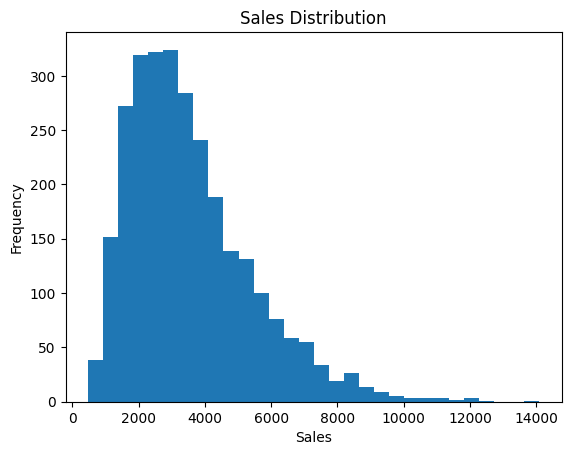

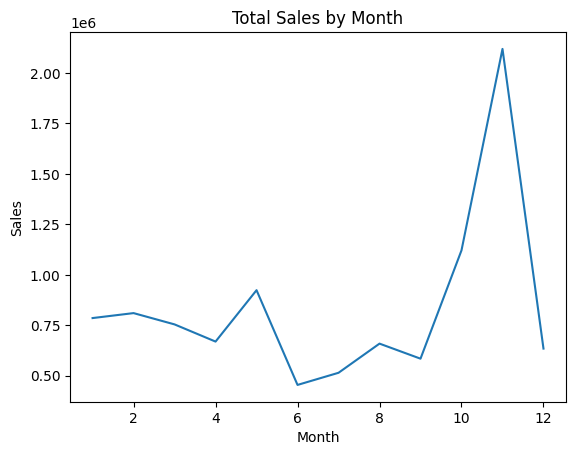

In [23]:
# ------------------------------------------
# 9. SIMPLE PLOTS
# ------------------------------------------

# Sales Distribution
plt.hist(df['SALES'], bins=30)
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title("Sales Distribution")
plt.show()

# Sales by Month
df.groupby('Order_Month')['SALES'].sum().plot(kind='line')
plt.title("Total Sales by Month")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.show()

In [27]:
# ------------------------------------------
# 10. SAVE CLEANED FILE
# ------------------------------------------

df.to_csv("sales_data_cleaned.csv", index=False)

print("\nCleaning, EDA, and preprocessing completed!")
print("Saved as: sales_data_cleaned.csv")


Cleaning, EDA, and preprocessing completed!
Saved as: sales_data_cleaned.csv


In [31]:
# Top products
def load_and_clean(filepath):
    df = pd.read_csv("C:/Users/Admin/Desktop/Radhika work/Zeta Work/sales_data_sample.csv", encoding='latin1')


df_clean = load_and_clean("C:/Users/Admin/Desktop/Radhika work/Zeta Work/sales_data_sample.csv")

# Save cleaned dataset
df_clean.to_csv("sales_data_cleaned.csv", index=False)
print("\n🔹 Top 10 Products by Sales:")
print(top_10_products(df_clean))

AttributeError: 'NoneType' object has no attribute 'to_csv'

In [67]:
#Import Libraries
import numpy as np
import pandas as pd

In [68]:
#Load the Data
data = pd.read_csv("C:/Users/Admin/Desktop/Radhika work/Zeta Work/sales_data_sample.csv", encoding='latin1')

In [69]:
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [70]:
#Check Null and duplicate values
print(data.isnull().sum())
data.duplicated().any()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64


np.False_

In [71]:
#as there are null values available and no duplicates so we will process the data accordingly
def fillmissing_values (data):
    #for munerical columns
    num_col = data.select_dtypea(include=['int64', 'float64']).columns
    for col in num_col:
        data[col] = data[col].fillna(data[col].median())

    #for categorical Columns
    cat_col = data.select.dtypes(include=['object64']).columns
    for col in cat_col:
        data[col] = data['col'].fillna(data[col].mode())

    return data

data = fill_missing_values(data)

In [72]:
#convert the date column into date format
def convert_dates(data, ORDERDATE):
    for col in ORDERDATE:
        data[col] = pd.to_datetime(data[col])
    return data

In [73]:
data.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [75]:
data = convert_dates(data, ['ORDERDATE'])

TypeError: 'NoneType' object is not subscriptable